Detected 13 out of 53 events (24.5%).
Saved 53 event records to /home/hajjohn1/bachelors-thesis/Clean/IF/IF/eval_event_detection_iforest_run_continue_memopt_20250828_160714.json


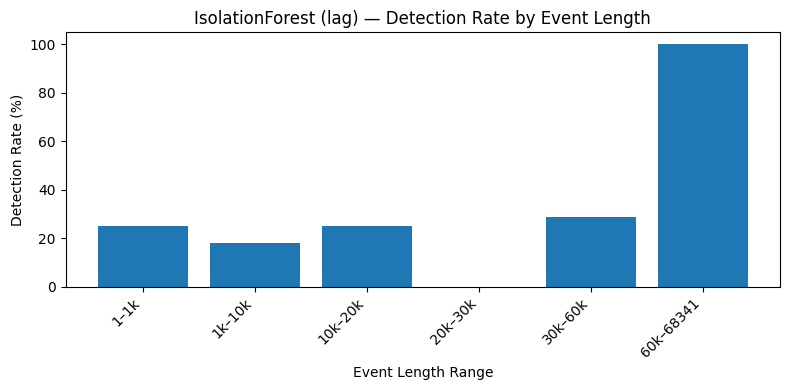

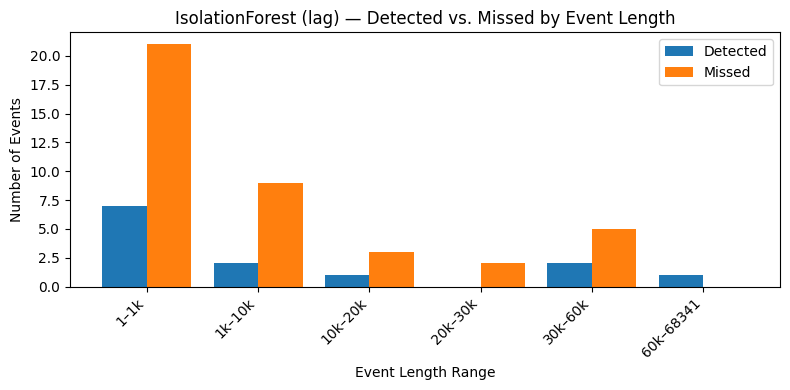

In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

# Paths
BASE_DIR       = Path("/home/hajjohn1/bachelors-thesis")
EVAL_PATH      = BASE_DIR / "data" / "evalrf_lag.parquet"

# using the exact continuation run folder where results were saved 
RUN_DIR        = BASE_DIR / "Clean" / "IF" / "lag" / "run_continue_memopt_20250828_160714"
MODEL_PATH     = RUN_DIR / "iforest_model.pkl"
SCALER_PATH    = RUN_DIR / "scaler.pkl"          # << load scaler (also saved previously)
FEATURES_PATH  = RUN_DIR / "features.json"
THRESHOLD_PATH = RUN_DIR / "threshold.json"

OUTPUT_DIR     = BASE_DIR / "Clean" / "IF" / "IF"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load stuff
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)

model   = joblib.load(MODEL_PATH)
scaler  = joblib.load(SCALER_PATH)               # << apply same scaler
with open(THRESHOLD_PATH, 'r') as f:
    threshold = json.load(f)["threshold_value"]

# Load eval data
eval_df = pd.read_parquet(EVAL_PATH)

# safety, isn't needed actually since we make sure no missing values are present in the dataset. HOwever it helps when testing different datasets
missing = [c for c in features if c not in eval_df.columns]
if missing:
    raise ValueError(f"Missing features in eval data: {missing}")

X_eval_raw = eval_df[features].to_numpy(dtype=np.float32, copy=False)
X_eval     = scaler.transform(X_eval_raw)        # << scale like during tuning
y_eval     = eval_df["is_anomaly"].to_numpy(dtype=np.int8, copy=False)

# Scores & preds 
scores = -model.decision_function(X_eval)        
preds  = (scores >= threshold).astype(np.int8)

assert len(preds) == len(eval_df), "Length mismatch eval/preds."

# Event IDs from ground truth
mask        = (eval_df['is_anomaly'] == 1)
event_start = mask & (~mask.shift(fill_value=False))
event_ids   = event_start.cumsum()
eval_df     = eval_df.copy()
eval_df['event_id'] = np.where(mask, event_ids, np.nan)

# Event detection
events = []
for eid, grp in eval_df[mask].groupby('event_id'):
    idx = grp.index.to_numpy()
    detected = bool(preds[idx].sum() > 0)
    events.append({'event_id': int(eid), 'length': int(len(grp)), 'detected': detected})

total_events   = len(events)
detected_count = sum(e['detected'] for e in events)
rate = (detected_count / total_events * 100) if total_events > 0 else 0.0
print(f"Detected {detected_count} out of {total_events} events ({rate:.1f}%).")

# Save JSON
run_id   = RUN_DIR.name
out_path = OUTPUT_DIR / f"eval_event_detection_iforest_{run_id}.json"
with open(out_path, 'w') as f:
    json.dump({'model': run_id, 'threshold': float(threshold), 'events': events}, f, indent=2)
print(f"Saved {total_events} event records to {out_path}")

# Plots
df_events = pd.DataFrame(events)[['length','detected']]
if not df_events.empty:
    max_len = int(df_events['length'].max())
    bins    = [1, 1_000, 10_000, 20_000, 30_000, 60_000, max_len + 1]
    labels  = ["1–1k","1k–10k","10k–20k","20k–30k","30k–60k", f"60k–{max_len}"]

    df_events['length_bin'] = pd.cut(df_events['length'], bins=bins, labels=labels, right=False, include_lowest=True)
    grouped = df_events.groupby('length_bin', observed=True)['detected'].agg(total_events='count', detected_events='sum').reindex(labels).fillna(0)
    grouped['detection_rate'] = grouped['detected_events'] / grouped['total_events'].replace(0, np.nan) * 100

    # Detection rate by length bin
    plt.figure(figsize=(8,4))
    plt.bar(grouped.index.astype(str), grouped['detection_rate'])
    plt.xlabel('Event Length Range'); plt.ylabel('Detection Rate (%)')
    plt.title('IsolationForest (lag) — Detection Rate by Event Length')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    # Counts: detected vs missed
    undetected = grouped['total_events'] - grouped['detected_events']
    x = np.arange(len(grouped.index)); width = 0.4
    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, grouped['detected_events'], width, label='Detected')
    plt.bar(x + width/2, undetected, width, label='Missed')
    plt.xticks(x, grouped.index.astype(str), rotation=45, ha='right')
    plt.xlabel('Event Length Range'); plt.ylabel('Number of Events')
    plt.title('IsolationForest (lag) — Detected vs. Missed by Event Length')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No anomaly events in eval; skipping plots.")
